# Attention is all you need

Adapted from https://colab.research.google.com/github/crazycloud/dl-blog/blob/master/_notebooks/2021_03_18_Transformers_Multihead_Self_Attention_Explanation_%26_Implementation_in_Pytorch.ipynb and http://nlp.seas.harvard.edu/annotated-transformer/

## Preliminaries

In [1]:
import math
import copy

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

2.0.1
True


## Self-attention

$d_E$ - embedding dim: The word embedding dimension and also the dimension for each key, value and query vectors. We assume each word is a $d_E$ dimension vector and we use a Linear Layer to Transform the token vector in to $K, V, Q$ vector of $d_k$ dimension. The reason to transform it into $d_E$ dimension is related to Multiheads where we calculate attention for multiple heads. We will add the multihead after implementing a simple self attention module

$n$ - sequence length: Maximum number of vectors to process at a time

In [3]:
n = 5 # 5 words sequence length (in practice this would include padding)
d_E = 256 # dimension of word embedding
d_k = 256 # dimension of key/query projection
d_v = d_k # dimension of value projection

In [4]:
torch.manual_seed(123)

In [5]:
# generate random sample data
n_B = 10
x = torch.randn(n_B, n, d_E) # (n, d_E)
print(x.shape)

torch.Size([10, 5, 256])


If we consider batch dimension as well the input will be of shape $(n_B, n, d_E)$

Transform input sequence $X$ into [key, query, value] of dimension $d_k$ (assume $d_k = d_v$ for now)
$x \rightarrow q, k, v$

In [6]:
# projection matrices Q, K, V
query_lin = nn.Linear(d_E, d_k, bias=False) 
key_lin = nn.Linear(d_E, d_k, bias=False)
val_lin = nn.Linear(d_E, d_v, bias=False)

q = query_lin(x) 
k = key_lin(x) 
v = val_lin(x)
# what is shape of q, k, v?

In [7]:
print(q.shape, k.shape, v.shape) # (n_B, n, d_v)

torch.Size([10, 5, 256]) torch.Size([10, 5, 256]) torch.Size([10, 5, 256])


Now compute attention scores with scalled dot product attention: 
$$\mathsf{softmax}_j\left(\frac{(XQ)(XK)^\top}{\sqrt{d_k}}\right)(XV) $$

In [8]:
def attention(query, key, value):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    p_attn = scores.softmax(dim=-1)
    return torch.matmul(p_attn, value), p_attn

In [9]:
x, attn_score = attention(q, k, v)
# what is shape of x, attn_score?

In [10]:
print(x.shape, attn_score.shape) # (n_B, n, d_v) and (n_B, n, n)

torch.Size([10, 5, 256]) torch.Size([10, 5, 5])


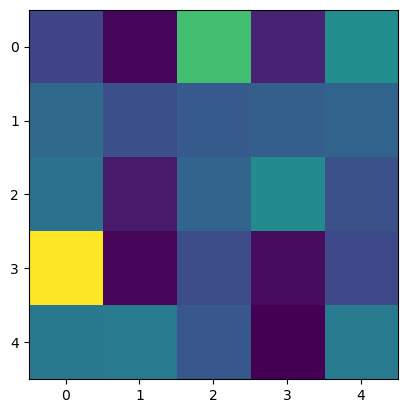

In [11]:
plt.imshow(attn_score[0].detach().numpy())

### Same thing as a module

https://magazine.sebastianraschka.com/p/understanding-and-coding-self-attention

In [12]:
class SelfAttention(nn.Module):

    def __init__(self, d_in, d_out_kq, d_out_v):
        super().__init__()
        self.d_out_kq = d_out_kq
        self.W_query = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_key   = nn.Parameter(torch.rand(d_in, d_out_kq))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out_v))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        
        attn_scores = queries @ keys.transpose(-1, -2)  # unnormalized attention weights    
        attn_weights = torch.softmax(
            attn_scores / self.d_out_kq**0.5, dim=-1
        )
        
        context_vec = attn_weights @ values
        return context_vec, attn_weights

In [13]:
self_attn = SelfAttention(d_E, d_k, d_v)

## Multi-head self attention

Multi-head self attention is defined as
$$\mathsf{MultiHead}(X) = [\mathsf{head}_1,\dots,\mathsf{head}_h]W^O$$
where 
$$ \mathsf{head}_i = \mathsf{Attention}(XQ_i, XK_i, XV_i)$$

In [14]:
# simpler version
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out_kq, d_out_v, num_heads):
        super().__init__()
        self.heads = nn.ModuleList(
            [SelfAttention(d_in, d_out_kq, d_out_v) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [22]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None

    def forward(self, query, key, value):
        "Implements Figure 2"
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        print(self.linears[0](query).shape)
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]
        # QUESTION: what would print(query.shape, key.shape, value.shape) give?
        print(query.shape, key.shape, value.shape)
        # what about before the view? i.e. the output of lin(x)?

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value)
        # QUESTION: what would print(x.shape) give?
        print(x.shape)

        # 3) "Concat" using a view
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        # QUESTION: what would print(x.shape) give?
        print(x.shape)
        del query
        del key
        del value
        
        # apply a final linear
        return self.linears[-1](x)

In [23]:
d_out = 256
h = 8
mha = MultiHeadedAttention(h, d_out) # what is d_v if d_out = 256 and h = 8?

In [24]:
x = mha(x, x, x)

torch.Size([10, 5, 256])
torch.Size([10, 8, 5, 32]) torch.Size([10, 8, 5, 32]) torch.Size([10, 8, 5, 32])
torch.Size([10, 8, 5, 32])
torch.Size([10, 5, 256])


In [18]:
print(x.shape)

torch.Size([10, 5, 256])


Answers:
- $(n_B, n, h*d_k)$
- $(n_B, h, n, d_k)$ or $n_B, h, n, d_v)$
- $(n_B, h, n, d_v)$
- $(n_B, n, h *d_v)$
- $(n_B, n, d_{model})$